In [2]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
import random
import time
import pickle
import datetime
import siren
from siren import SIREN
from PIL import Image
from coordx import coordx_net
from helpers import psnr
import matplotlib.pyplot as plt
import numpy as np

In [21]:
MODEL_DIR = "models/"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
# defining the model
layers = [256, 256, 256, 256, 256]
in_features = 2
out_features = 3
initializer = 'siren'
w0 = 1.0
w0_initial = 30.0
c = 6
siren_model = SIREN(
    layers, in_features, out_features, w0, w0_initial,
    initializer=initializer, c=c).to(device)

In [23]:
coordx_model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)

In [25]:
# Put things together to sim inference with different models (shouldn't matter if trained)
siren_model.eval()
coordx_model.eval()
img_sizes = [256, 512, 1024, 2048]
siren_times_gpu = []
coordx_times_gpu = []
for size in img_sizes:
    x = torch.linspace(1, size, size).reshape(-1,1).to(device)
    y = torch.linspace(1, size, size).reshape(-1,1).to(device)
    x_grid, y_grid = torch.meshgrid(torch.linspace(-1.0,1.0, size, device=device),torch.linspace(-1.0,1.0,size, device=device))
    x_in = torch.cat((torch.unsqueeze(x_grid, dim=2), torch.unsqueeze(y_grid, dim=2)), dim = 2,).to(device)
    print(x_in.shape)
    print(x.shape, y.shape)
    
    coordt = []
    for i in range(12):
        inf_time = time.perf_counter()
        with torch.no_grad():
            out = coordx_model([x,y])
        inf_time = time.perf_counter() - inf_time
        coordt.append(inf_time)
    coordx_times_gpu.append(sum(coordt)/12)

    sirent = []
    for i in range(12):
        inf_time = time.perf_counter()
        with torch.no_grad():
            out = siren_model(x_in)
        inf_time = time.perf_counter() - inf_time
        sirent.append(inf_time)
    siren_times_gpu.append(sum(sirent)/12)
    

torch.Size([256, 256, 2])
torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([512, 512, 2])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([1024, 1024, 2])
torch.Size([1024, 1]) torch.Size([1024, 1])
torch.Size([2048, 2048, 2])
torch.Size([2048, 1]) torch.Size([2048, 1])


In [41]:
print(siren_times, coordx_times)

[0.00037882499994642177, 0.00041410833334036096, 0.0004359749996183382, 0.0006222083332734959] [0.000763450000249577, 0.0005891333335057425, 0.0006507083336752354, 0.0006932749997758947]


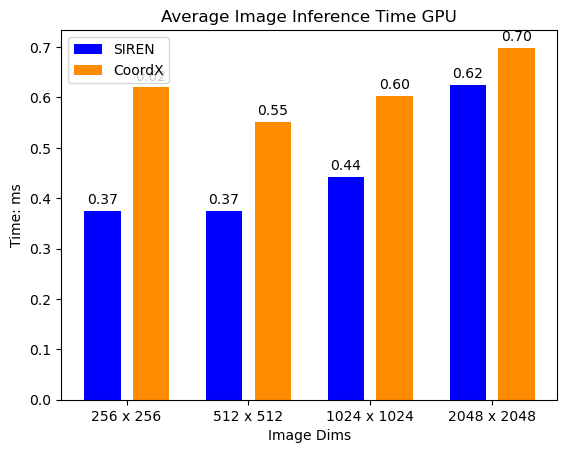

In [34]:
categories = ['256 x 256', '512 x 512', '1024 x 1024', '2048 x 2048']
scaled_siren_times = [x*1000 for x in siren_times_gpu]
scaled_coordx_times = [x*1000 for x in coordx_times_gpu]

x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots()
X_axis = np.arange(len(categories)) 

# Plotting the bars
bars1 = ax.bar(X_axis -0.2, scaled_siren_times, color='blue', width=0.3, label='SIREN')
bars2 = ax.bar(X_axis  + 0.2, scaled_coordx_times, color='darkorange', width=0.3, label='CoordX')



# Adding labels
ax.set_xlabel('Image Dims')
ax.set_ylabel('Time: ms')
ax.set_xticks(X_axis, categories)
ax.set_title('Average Image Inference Time GPU')
ax.legend()

for p in bars1:
   height = p.get_height()
   ax.annotate('{:.2f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
   

for p in bars2:
   height = p.get_height()
   ax.annotate('{:.2f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

# Showing plot
plt.show()

In [20]:
print(siren_times, coordx_times)

[0.0005977000000711996, 0.000513300001330208, 0.0005906999995204387, 0.0007006000014371239] [0.0017499000005045673, 0.0011199000000488013, 0.0012753999999404186, 0.0012055000006512273]


In [ ]:
# inference numbers are hilariously low for some reason, did they test on cpu?

In [4]:
# defining the model
layers = [256, 256, 256, 256, 256]
in_features = 2
out_features = 3
initializer = 'siren'
w0 = 1.0
w0_initial = 30.0
c = 6
siren_model = SIREN(
    layers, in_features, out_features, w0, w0_initial,
    initializer=initializer, c=c)

coordx_model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1)

In [5]:
# Put things together to sim inference with different models (shouldn't matter if trained)
siren_model.eval()
coordx_model.eval()
img_sizes = [256, 512, 1024, 2048]
siren_times = []
coordx_times = []
for size in img_sizes:
    x = torch.linspace(1, size, size).reshape(-1,1)
    y = torch.linspace(1, size, size).reshape(-1,1)
    x_grid, y_grid = torch.meshgrid(torch.linspace(-1.0,1.0, size),torch.linspace(-1.0,1.0,size))
    x_in = torch.cat((torch.unsqueeze(x_grid, dim=2), torch.unsqueeze(y_grid, dim=2)), dim = 2,)
    print(x_in.shape)
    print(x.shape, y.shape)
    
    coordt = []
    for i in range(12):
        inf_time = time.perf_counter()
        with torch.no_grad():
            out = coordx_model([x,y])
        inf_time = time.perf_counter() - inf_time
        coordt.append(inf_time)
    coordx_times.append(sum(coordt)/12)

    sirent = []
    for i in range(12):
        inf_time = time.perf_counter()
        with torch.no_grad():
            out = siren_model(x_in)
        inf_time = time.perf_counter() - inf_time
        sirent.append(inf_time)
    siren_times.append(sum(sirent)/12)
    

c:\Users\Andrew\anaconda3\envs\eecs6322-a1\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([256, 256, 2])
torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([512, 512, 2])
torch.Size([512, 1]) torch.Size([512, 1])
torch.Size([1024, 1024, 2])
torch.Size([1024, 1]) torch.Size([1024, 1])
torch.Size([2048, 2048, 2])
torch.Size([2048, 1]) torch.Size([2048, 1])


In [6]:
print(siren_times, coordx_times)

[0.31174010000040653, 1.3315621416666847, 5.241790041666415, 20.218268533333383] [0.08318421666687452, 0.30994171666664744, 1.3255588749993876, 5.100121883333486]


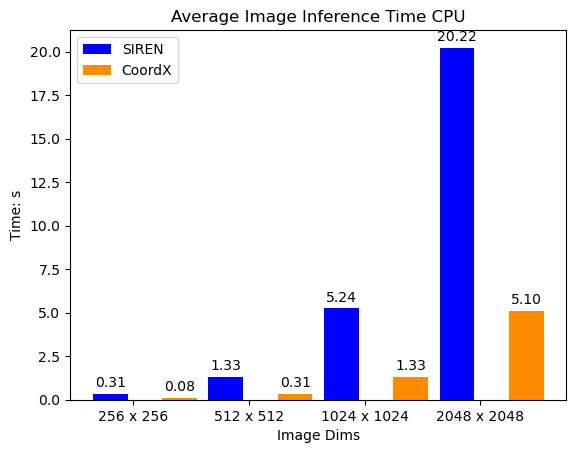

In [36]:
categories = ['256 x 256', '512 x 512', '1024 x 1024', '2048 x 2048']

x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots()
# Plotting the bars
bars1 = ax.bar(x - 0.2, siren_times, color='blue', width=0.3, label='SIREN')
bars2 = ax.bar(x + 0.4, coordx_times, color='darkorange', width=0.3, label='CoordX')

# Adding labels
ax.set_xlabel('Image Dims')
ax.set_ylabel('Time: s')
ax.set_xticks(x, categories)
ax.set_title('Average Image Inference Time CPU')
ax.legend()

for p in bars1:
   height = p.get_height()
   ax.annotate('{:.2f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
   

for p in bars2:
   height = p.get_height()
   ax.annotate('{:.2f}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

# Showing plot
plt.show()